# Elementary cellular automaton

## Imports

In [1]:
from typing import Final
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pydantic import BaseModel, Field, PositiveInt, PrivateAttr

In [2]:
class Rules:
    """Rule is considered to be an ordered triple of booleans, representing the state for which the values is updated to True."""
    _25 = [[True, False, False], [False, True, True], [False, False, False]]
    _26 = [[True, False, False], [False, True, True], [False, False, True]]
    _30 = [[True, False, False], [False, True, True], [False, True, False], [False, False, True]]
    # _73 = [, [[False, False, False]]]

In [3]:
[False, False, False] in  Rules._25
'{0:08b}'.format(73)

'01001001'

In [4]:
class WolframModel:
    def __init__(self, n: int, t: int, c0: float | None = None, init_state: np.ndarray | None = None) -> None:
        if init_state is not None:
            if len(init_state.shape) > 1:
                msg = "Expected 1D array as init state."
                raise ValueError(msg)
            elif init_state.shape[0] != n:
                msg = "Init state shape does not match space shape."
                raise ValueError(msg)
        elif c0 is None:
            msg = "Neither init_state nor c0 is initiated."
            raise ValueError(msg)
        self.n = n
        self.t = t
        self.c0 = c0
        self.init_state = init_state

        self._rules = None
    
    def set_rules(self, rules: list[list[bool]]) -> None:
        self._rules = rules
    
    def run(self):
        self._pre_init_simulation()
        for i in range(self.t):
            self._update(i)
        
    def _pre_init_simulation(self) -> None:
        self.graph = self._init_graph()
    
    def _init_graph(self) -> np.ndarray[bool]:
        graph_evolution = np.zeros((self.t+1, self.n), dtype=bool)
        if self.init_state is not None:
            graph_evolution[0,:] = self.init_state
        else:
            init = np.random.choice([True, False], size=self.n, p=[self.c0, 1 - self.c0])
            graph_evolution[0,:] = init
        return graph_evolution
    
    def _update(self, step: PositiveInt):
        """Each update corresponds with n atomic updates. From the other side we 
        store simulation in frame (t + 1 x n) that means we apply for each row 
        state after n atomic updates.
        
        Have in mind that first row is an initial state. Therefore i-th update
        row corresponds with i-th + 1 graph evolution row. 
        """
        for idx in range(self.n):
            self._apply_rules(x=step+1, y=idx)
            
    
    def _apply_rules(self, x: int, y: int) -> None:
        influencers = self.graph[x - 1, [(y + i) % self.n for i in range(-1, 2)]]
        for rule in self._rules:
            if influencers.tolist() in rule:
                self.graph[x, y] = True
                break
    
    def get_graph_evolution(self) -> np.ndarray:
        return np.vectorize(lambda x: x.value)(self.graph)


In [5]:
init_state = np.zeros(100, dtype= bool)
init_state[50] = True
model = WolframModel(100, 100, init_state = init_state)
model.set_rules([Rules._30])

In [6]:
model.run()

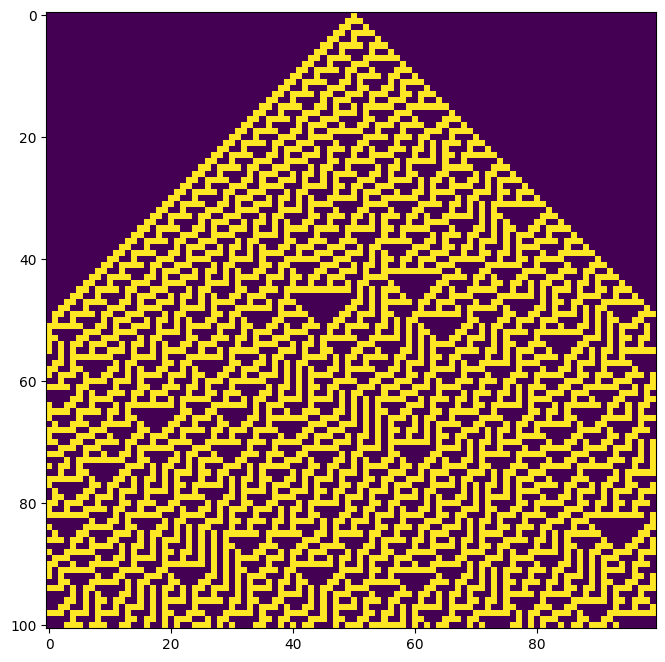

In [7]:
fig, current_ax = plt.subplots(1, 1, figsize=(8,8))
current_ax.imshow(model.graph, cmap='viridis', interpolation='nearest')

In [8]:
class WolframModel_v2(WolframModel):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self._rule: dict[int, bool] | None = None

    def set_rules(self, rules: list[list[bool]]) -> None:
        msg = "This is no longer supproted in v2. Try set_rule."
        raise NameError(msg)
    
    def set_rule(self, rule_number: int) -> None:
        """Rule bits represent the given number in binary but in reverse order
        corresponding orderring in wolfram.
        """
        if not (0 <= rule_number <= 255):
            msg = "rule_number must be 0..255"
            raise ValueError(msg)
        rule_bits = [(rule_number >> i) & 1 for i in range(8)]
        self._rule =  {i: bool(rule_bits[i]) for i in range(8)}
    
    def _update(self, step: PositiveInt):
        """In order to improve efficiency we use bitwise opperations on
        overall rows. We convert binary values and compute orr to get one 
        binary number of the rule.
        """
        left = np.roll(self.graph[step], 1)
        center = self.graph[step]
        right = np.roll(self.graph[step], -1)
        neighborhood = (left << 2) | (center << 1) | right
        vec_table = np.array([self._rule[i] for i in range(8)], dtype=np.uint8)
        self.graph[step+1] = vec_table[neighborhood]
            
    
    def _apply_rules(self, x: int, y: int) -> None:
        msg = "This is no longer supproted in v2."
        raise NameError(msg)
    
    def get_graph_evolution(self) -> np.ndarray:
        return np.vectorize(lambda x: x.value)(self.graph)


In [9]:
init_state = np.zeros(100, dtype= bool)
init_state[50] = True
model = WolframModel_v2(100, 100, init_state = init_state)
model.set_rule(109)

In [10]:
model.run()

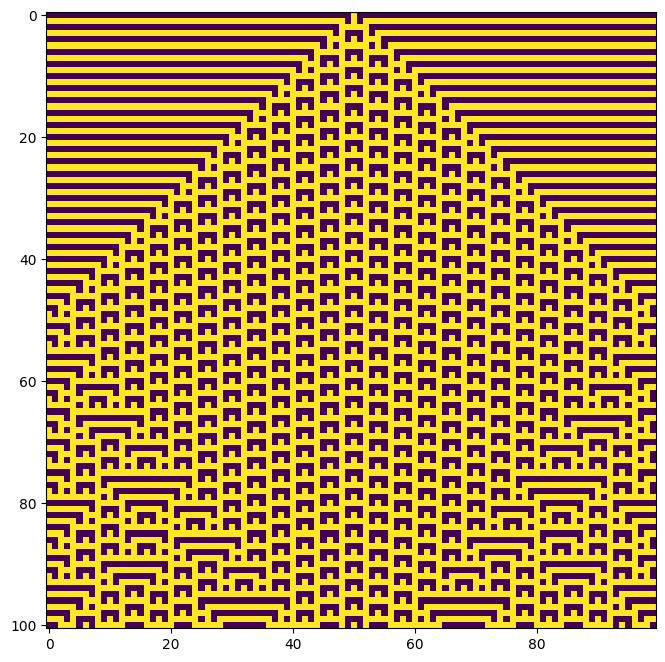

In [11]:
fig, current_ax = plt.subplots(1, 1, figsize=(8,8))
current_ax.imshow(model.graph, cmap='viridis', interpolation='nearest')

In [12]:
init_state = np.zeros(100, dtype= bool)
model = WolframModel_v2(100, 100, c0 = 0.4)
model.set_rule(109)

In [13]:
model.run()

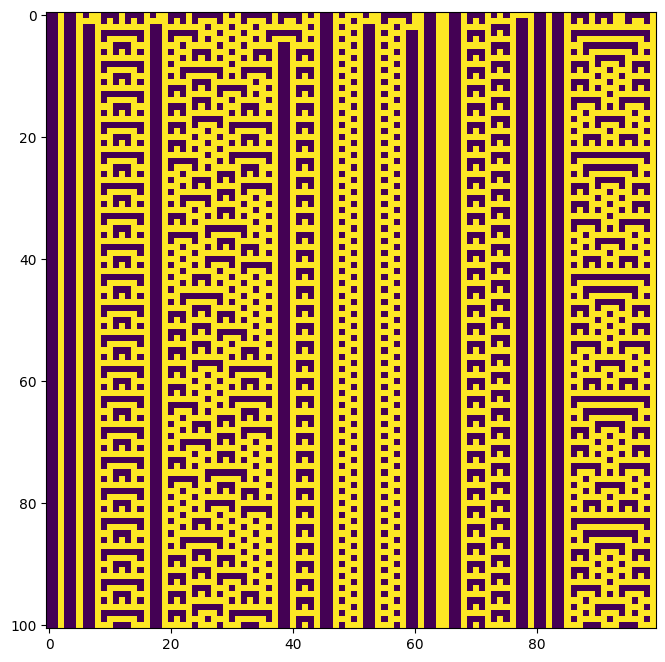

In [14]:
fig, current_ax = plt.subplots(1, 1, figsize=(8,8))
current_ax.imshow(model.graph, cmap='viridis', interpolation='nearest')

In [15]:
class WolframModel_v3(WolframModel_v2):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self._was_run: bool = False
    
    def run(self):
        super().run()
        self._was_run = True

    def run_one_step(self):
        self._pre_init_simulation()
        self._update(0)
        self._was_run = True
    
    def get_one_step_simulation_results(self) -> np.ndarray:
        if not self._was_run:
            msg = "Simulation was not run."
            raise ValueError(msg)
        return self.graph[1]

In [16]:
def task4(rule_number: int) -> None:
    n = 5
    G = nx.DiGraph()
    for idx in range(2 ** 5):
        model = WolframModel_v3(n=5, t=2, init_state=int_to_state(idx, n))
        model.set_rule(rule_number)
        model.run_one_step()
        next_state = state_to_int(model.get_one_step_simulation_results())
        G.add_edge(idx, next_state)
    
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos,
        node_size=200,
        node_color="lightblue",
        arrows=True,
        with_labels=True,
        font_size=8
    )
    plt.title(f"ECA Configuration Space (Rule {rule_number}, width={n})")
    plt.show()
    print(f"Number of nodes: {len(G.nodes())}")
    print(f"Number of edges: {len(G.edges())}")

def int_to_state(n, width):
    return np.array([(n >> i) & 1 for i in reversed(range(width))], dtype=np.uint8)

def state_to_int(state):
    return int(''.join(str(int(x)) for x in state), 2)

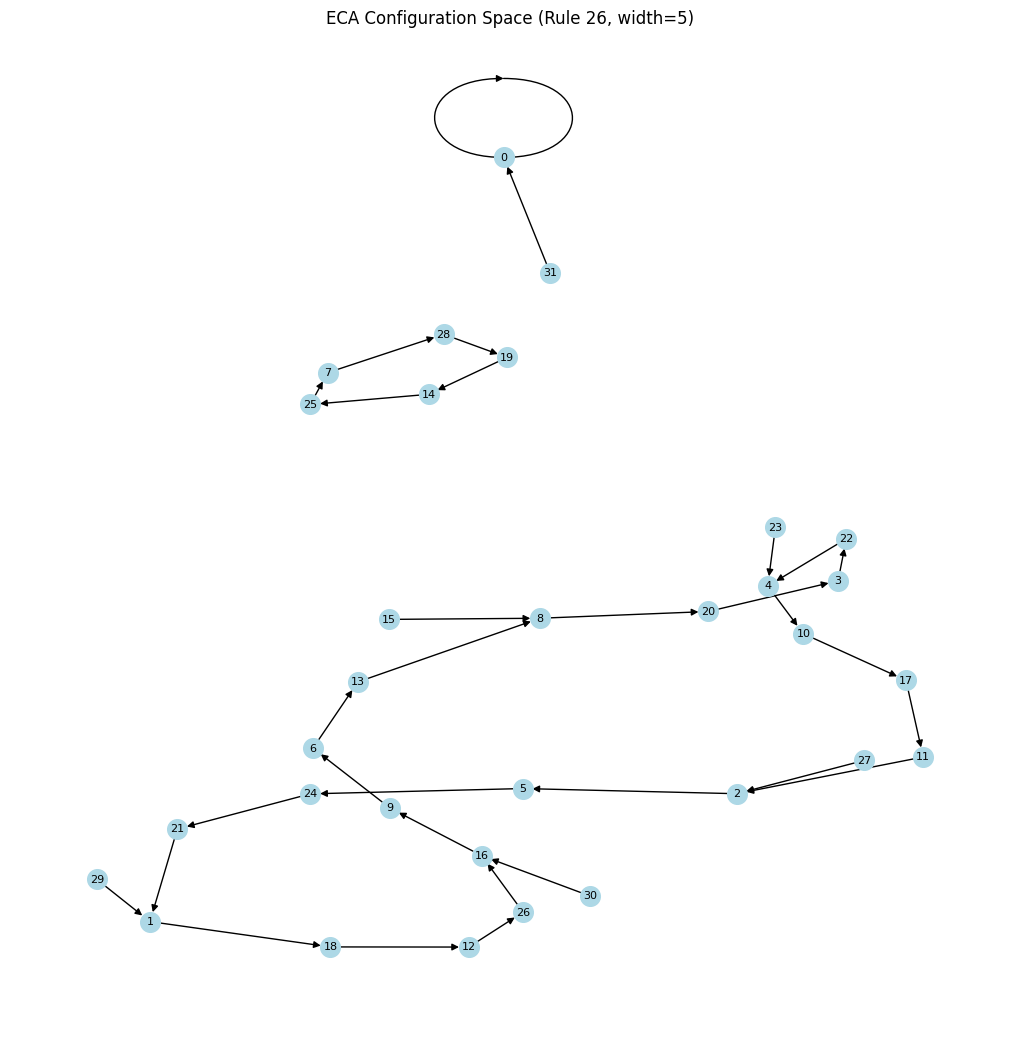

Number of nodes: 32
Number of edges: 32


In [17]:
task4(26)

In [18]:
def get_graph(rule_number: int) -> None:
    n = 5
    G = nx.DiGraph()
    for idx in range(2 ** 5):
        model = WolframModel_v3(n=5, t=2, init_state=int_to_state(idx, n))
        model.set_rule(rule_number)
        model.run_one_step()
        next_state = state_to_int(model.get_one_step_simulation_results())
        G.add_edge(idx, next_state)
    return G

In [27]:
def task2():
    rules = [25, 26, 30, 73, 126, 110,11, 1, 109]
    init_state = np.zeros(100, dtype=np.bool)
    init_state[49] = True
    model_deterministic = WolframModel_v2(n=100, t=100, init_state=init_state)
    c0 = 0.4
    model_random = WolframModel_v2(n=100, t=100, c0=c0)

    rows, cols = len(rules), 5
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharex=False)
    fig.text(0.2, 1.01, "1 in middle", fontsize=18)
    fig.text(0.7, 1.01, f"$c_0={c0}$", fontsize=18)
    for row_no, rule in enumerate(rules):
        model_deterministic.set_rule(rule)
        model_deterministic.run()
        ones_deterministic = model_deterministic.graph.sum(axis=1)
        activity_deterministic = np.diff(model_deterministic.graph, axis=0).sum(axis=1)
        diffs = np.diff(model_deterministic.graph, axis=1)
        wrapped_diff = np.logical_xor(model_deterministic.graph[:, 0], model_deterministic.graph[:, -1]).reshape(1, -1)
        diffs_deterministic = np.hstack([diffs, wrapped_diff.T]).sum(axis=1)

        model_random.set_rule(rule)
        model_random.run()
        ones_random = model_random.graph.sum(axis=1)
        activity_random = np.diff(model_random.graph, axis=0).sum(axis=1)
        diffs = np.diff(model_random.graph, axis=1)
        wrapped_diff = np.logical_xor(model_random.graph[:, 0], model_random.graph[:, -1]).reshape(1, -1)
        diffs_random = np.hstack([diffs, wrapped_diff.T]).sum(axis=1)
        
        ax = axs.flatten()[5*row_no]
        ax.set_title(f"Rule {rule}")
        ax.set_xlabel("Space")
        ax.set_ylabel("Step")
        ax.imshow(model_deterministic.graph, cmap='viridis', interpolation='nearest')
        
        
        ax = axs.flatten()[5*row_no+1]
        ax.set_title(f"Rule {rule}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Count")
        ax.plot(ones_deterministic, label="1's")
        ax.plot(activity_deterministic, label="activity")
        ax.plot(diffs_deterministic, label="active bounds")
        ax.legend()
        ax.grid(alpha=0.4)
        ax.set_ylim(
            0,
            max(
                ones_deterministic.max(),
                ones_random.max(),
                activity_deterministic.max(),
                activity_random.max(),
                diffs_deterministic.max(),
                diffs_random.max(),
            )
        )
        
        ax = axs.flatten()[5*row_no + 3]
        ax.set_title(f"Rule {rule}")
        ax.set_xlabel("Space")
        ax.set_ylabel("Step")
        ax.imshow(model_random.graph, cmap='viridis', interpolation='nearest')
        
        ax = axs.flatten()[5*row_no + 4]
        ax.set_title(f"Rule {rule}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Count")
        ax.plot(ones_random, label=f"1's")
        ax.plot(activity_random, label=f"activity")
        ax.plot(diffs_random, label=f"active bounds")
        ax.legend()
        ax.grid(alpha=0.4)
        ax.set_ylim(
            0,
            max(
                ones_deterministic.max(),
                ones_random.max(),
                activity_deterministic.max(),
                activity_random.max(),
                diffs_deterministic.max(),
                diffs_random.max(),
            )
        )
        ax = axs.flatten()[5*row_no + 2]
        transition_graph = get_graph(rule)
        pos = nx.spring_layout(transition_graph, seed=42)
        
        nx.draw(
        transition_graph,
        pos,
        ax=ax,
        node_size=100,
        node_color="lightblue",
        arrows=True,
        with_labels=True,
        font_size=8
    )
        ax.set_title(f"Rule {rule}(5 nodes)")
    fig.tight_layout()

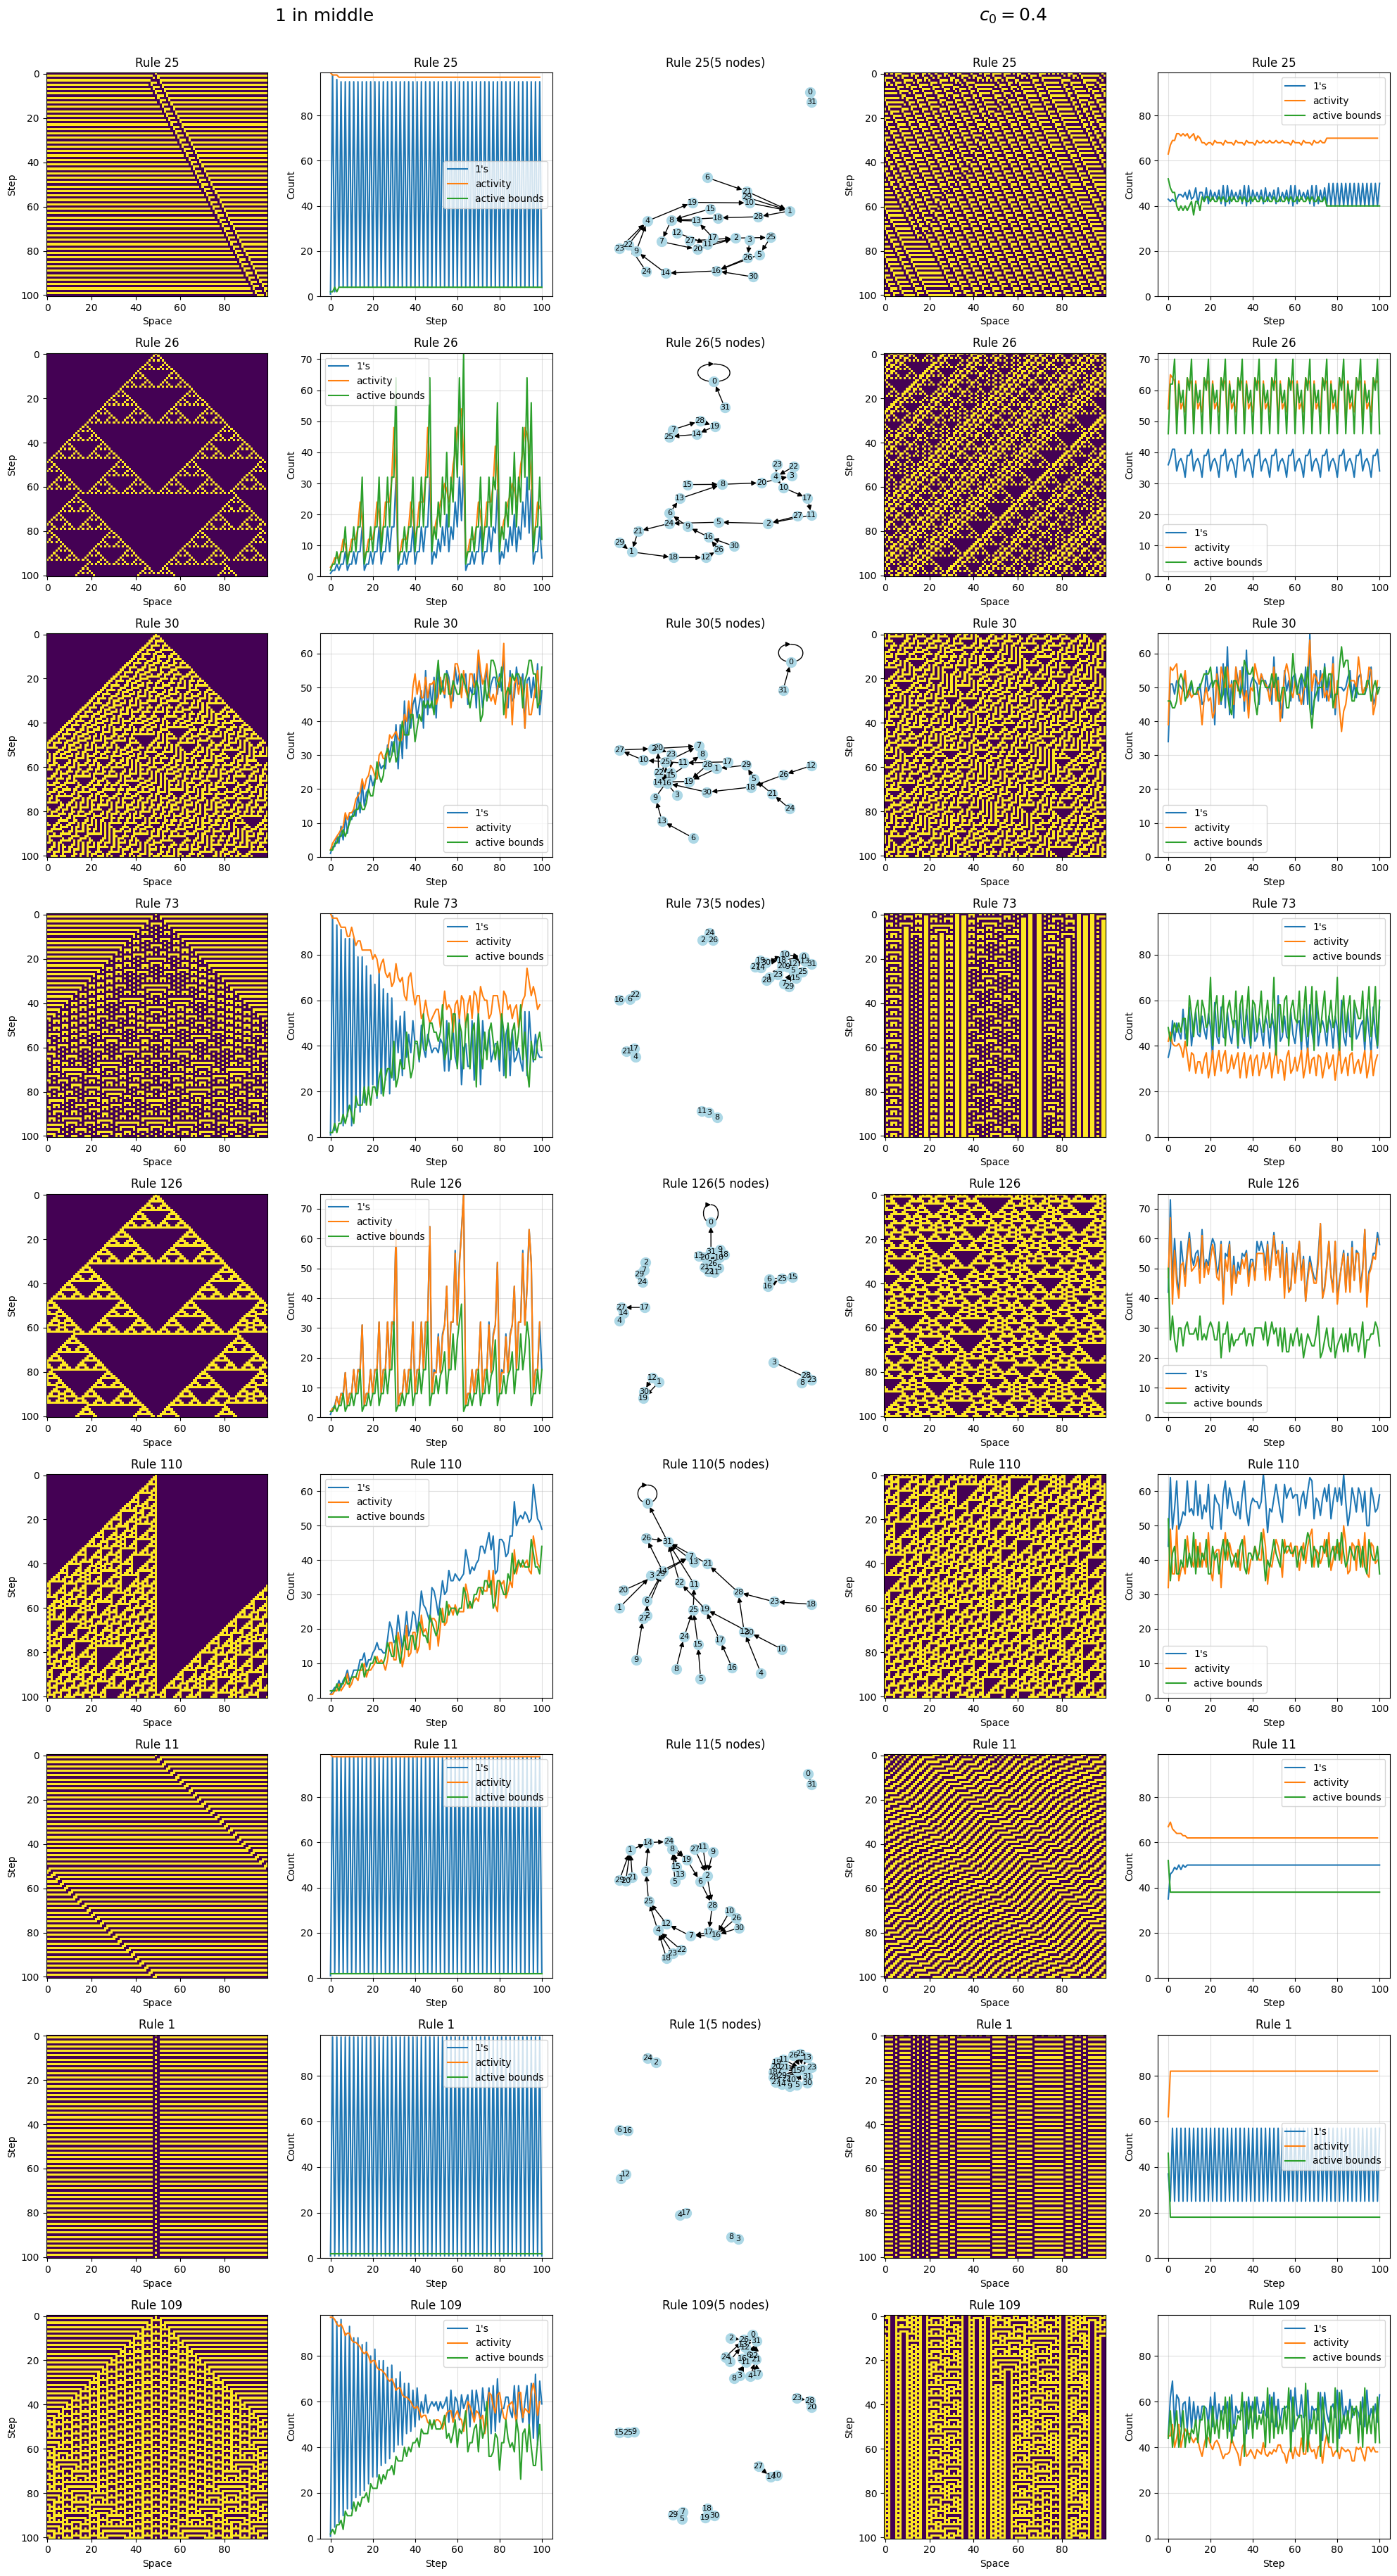

In [28]:
task2()